In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import os

from PIL import Image
import io
import base64
import math

import random
from sklearn.model_selection import train_test_split
from shapely.geometry import Polygon

In [2]:
def order_points_convex(points):
    """
    Orders the points to form a convex quadrilateral (rectangle).
    """
    if len(points) != 4:
        return points  # Only works for quadrilaterals
    
    # Calculate the centroid of the points
    centroid_x = sum(p[0] for p in points) / 4
    centroid_y = sum(p[1] for p in points) / 4
    
    # Sort points by angle relative to the centroid
    def angle_from_centroid(point):
        return math.atan2(point[1] - centroid_y, point[0] - centroid_x)
    
    sorted_points = sorted(points, key=angle_from_centroid)
    return sorted_points
    
def filter_images_with_4_plus_keypoints(directory):
    """
    Filters images that have polygons with more than 4 keypoints.
    Returns a list of file paths for such images.
    """
    json_files = [f for f in os.listdir(directory) if f.endswith(".json")]
    filtered_files = []

    for filename in json_files:
        json_path = os.path.join(directory, filename)
        with open(json_path, 'r') as f:
            keypoints = json.load(f)
        
        if "shapes" not in keypoints:
            continue
        
        for shape in keypoints["shapes"]:
            if len(shape["points"]) > 4:
                filtered_files.append(json_path)
                break  # Stop checking other shapes in the same file
    
    return filtered_files
    
def is_convex(points):
    """
    Checks if the given points form a convex polygon.
    """
    if len(points) < 3:
        return False  # A polygon must have at least 3 points
    
    polygon = Polygon(points)
    return polygon.is_valid and polygon.convex_hull.equals(polygon)
    
def ensure_rectangle_shape(points):
    """
    Ensures the points form a rectangle-shaped polygon.
    """
    if len(points) != 4:
        return points  # Only works for quadrilaterals
    
    # Order the points to form a convex quadrilateral
    ordered_points = order_points_convex(points)
    
    # Check if the ordered points form a convex polygon
    if is_convex(ordered_points):
        return ordered_points
    else:
        # If not convex, adjust the points slightly
        adjusted_points = [(x + 0.01 * i, y + 0.01 * i) for i, (x, y) in enumerate(ordered_points)]
        return adjusted_points


def find_closest_points(points):
    min_distance = float('inf')
    closest_pair = None
    
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            x1, y1 = points[i]
            x2, y2 = points[j]
            distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if distance < min_distance:
                min_distance = distance
                closest_pair = (i, j)
    
    return closest_pair
    
def replace_closest_points(points):
    if len(points) > 4:
        # Find the two closest points
        i, j = find_closest_points(points)
        # Calculate the midpoint of the two closest points
        midpoint = (
            (points[i][0] + points[j][0]) / 2,
            (points[i][1] + points[j][1]) / 2
        )
        # Replace the two closest points with the midpoint
        new_points = [point for idx, point in enumerate(points) if idx not in (i, j)]
        new_points.append(midpoint)
        return new_points
    return points
def reorder_points(points):
    """
    Reorders the points to ensure:
    - x1: top-left
    - x2: top-right
    - x3: bottom-right
    - x4: bottom-left
    """
    if len(points) != 4:
        return points  # Only works for quadrilaterals
    
    # Sort points by y-coordinate (top to bottom)
    sorted_by_y = sorted(points, key=lambda p: p[1])
    
    # Separate top and bottom points
    top_points = sorted_by_y[:2]  # Top two points (smallest y)
    bottom_points = sorted_by_y[2:]  # Bottom two points (largest y)
    
    # Sort top points by x-coordinate (left to right)
    top_points_sorted = sorted(top_points, key=lambda p: p[0])
    x1 = top_points_sorted[0]  # Top-left
    x2 = top_points_sorted[1]  # Top-right
    
    # Sort bottom points by x-coordinate (left to right)
    bottom_points_sorted = sorted(bottom_points, key=lambda p: p[0])
    x4 = bottom_points_sorted[0]  # Bottom-left
    x3 = bottom_points_sorted[1]  # Bottom-right
    
    # Return reordered points
    return [x1, x2, x3, x4]



In [3]:
label_data = []
label_dir = '/kaggle/input/surround-view-mmu-parking-slots-dataset/main_data/labels'
label_files = os.listdir('/kaggle/input/surround-view-mmu-parking-slots-dataset/main_data/labels')

In [4]:
for file_name in label_files:
    if file_name.endswith('.json'):
        with open(os.path.join(label_dir, file_name), 'r') as f:
            label_data.append(json.load(f))

In [5]:
rows = []
for labels in label_data:
    for shape in labels['shapes']:
        true_flags = [key for key, value in labels['flags'].items() if value]
        if len(true_flags) > 1:
            print("more than one")
        for flag in true_flags:
            row= ({
                'flag': flag, 
                'imagePath': labels['imagePath'],
                'imageHeight': labels['imageHeight'],
                'imageWidth': labels['imageWidth'],
                'label': shape['label'],
            })
            points = shape["points"]
            if len(points) > 4:
                continue

            for i, (x, y) in enumerate(points):
                row[f'x{i+1}'] = x
                row[f'y{i+1}'] = y
            rows.append(row)

data = pd.DataFrame(rows)
data.dropna()

flag      imagePath  imageHeight  imageWidth     label  \
0      perpendicular  0814_1764.jpg         1080        1080    vacant   
1      perpendicular  0814_1764.jpg         1080        1080  occupied   
2      perpendicular    0829_13.jpg         1080        1080  occupied   
3      perpendicular    0829_13.jpg         1080        1080  occupied   
4      perpendicular  0809_4123.jpg         1080        1080  occupied   
...              ...            ...          ...         ...       ...   
16186  perpendicular  0829_1738.jpg         1080        1080    vacant   
16187  perpendicular  0829_1738.jpg         1080        1080    vacant   
16188  perpendicular   0905_623.jpg         1080        1080    vacant   
16189  perpendicular   0905_623.jpg         1080        1080    vacant   
16190  perpendicular  0823_2368.jpg         1080        1080    vacant   

               x1          y1          x2          y2          x3          y3  \
0       96.395349  273.720930  335.930233  251.627907  449.883721  372.558140   
1      334.767442  249.302326  452.209302  371.395349  828.953488  271.395349   
2      522.142857  667.976190  543.571429  751.309524  116.190476  784.642857   
3      523.333333  669.166667  691.190476  650.119048  881.666667  703.690476   
4      808.390805  715.862069  556.666667  443.448276  740.574713  510.114943   
...           ...         ...         ...         ...         ...         ...   
16186   45.172414  868.735632  202.643678  661.839080  439.425287  672.183908   
16187  730.229885  796.321839  439.425287  671.034483  606.091954  673.333333   
16188  647.471264  698.620690  576.206897  630.804598  426.781609  652.643678   
16189  646.321839  696.321839  577.356322  631.954023  737.126437  604.367816   
16190  645.294118  664.705882  795.882353  768.235294  200.588235  785.882353   

                x4          y4  
0        12.674419  444.651163  
1       605.697674  200.465116  
2       320.952381  684.642857  
3       541.190476  748.928571  
4      1079.000000  790.574713  
...            ...         ...  
16186   730.229885  796.321839  
16187   993.448276  748.045977  
16188   276.206897  749.195402  
16189   988.850575  623.908046  
16190   408.823529  675.294118  

[16190 rows x 13 columns]

In [6]:
label_map = {"occupied": 0, "vacant": 1, "unavailable": 2}
reverse = {0: "occupied", 1: "vacant", 2: "unavailable"}


In [7]:
data.fillna(0, inplace=True)

In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=28)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12952 entries, 3866 to 9473
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   flag         12952 non-null  object 
 1   imagePath    12952 non-null  object 
 2   imageHeight  12952 non-null  int64  
 3   imageWidth   12952 non-null  int64  
 4   label        12952 non-null  object 
 5   x1           12952 non-null  float64
 6   y1           12952 non-null  float64
 7   x2           12952 non-null  float64
 8   y2           12952 non-null  float64
 9   x3           12952 non-null  float64
 10  y3           12952 non-null  float64
 11  x4           12952 non-null  float64
 12  y4           12952 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 1.4+ MB


In [10]:
# Create directories for train and val
os.makedirs("dataset/train/labels", exist_ok=True)
os.makedirs("dataset/val/labels", exist_ok=True)

In [11]:
# Number of unique groups
num_groups = len(train_data.groupby('imagePath'))
print("Number of unique groups:", num_groups)

# Find the longest group
group_sizes = train_data.groupby('imagePath').size()
longest_group = group_sizes.idxmax()  # Group with the maximum size
longest_group_size = group_sizes.max()  # Size of the longest group

print(f"Longest group: {longest_group} with {longest_group_size} entries")

Number of unique groups: 9000
Longest group: 0809_131.jpg with 4 entries


In [12]:
def save_yolo_format(data, output_dir):
    i = 0
    for image_path, group in data.groupby('imagePath'):
        # Construct the file name for the annotation file
        label_path = os.path.join(output_dir, image_path.replace(".jpg", ".txt"))
        with open(label_path, 'w+') as f:
            for _, row in group.iterrows():
                # Image dimensions
                img_width = row["imageWidth"]
                img_height = row["imageHeight"]
        
                # Normalize coordinates
                x1 = max(min(row["x1"] / img_width, 1), 0)
                y1 = max(min(row["y1"] / img_height, 1), 0)
                x2 = max(min(row["x2"] / img_width, 1), 0)
                y2 = max(min(row["y2"] / img_height, 1), 0)
                x3 = max(min(row["x3"] / img_width, 1), 0)
                y3 = max(min(row["y3"] / img_height, 1), 0)
                x4 = max(min(row["x4"] / img_width, 1), 0)
                y4 = max(min(row["y4"] / img_height, 1), 0)
        
                # Calculate bounding box
                x_center = (x1 + x2 + x3 + x4) / 4
                y_center = (y1 + y2 + y3 + y4) / 4
                width = max(x1, x2, x3, x4) - min(x1, x2, x3, x4)
                height = max(y1, y2, y3, y4) - min(y1, y2, y3, y4)
        
                # Get class ID
                class_id = label_map[row["label"]]
        
                # YOLO format
                yolo_row = [
                    class_id, x_center, y_center, width, height,
                    x1, y1, 2, x2, y2, 2, x3, y3, 2, x4, y4, 2
                ]

                norm = [
                     x_center, y_center, width, height,
                    x1, y1,  x2, y2, x3, y3, x4, y4
                ]
                
                # Applying checks to see if data is good to go
                if x1 < 0 or y1 < 0 or x2 < 0 or y2 < 0:
                    print(f"Invalid bounding box in {image_path}")
                    continue
                
                if width < 0 or height < 0:
                    print(f"Negative dimensions detected in {image_path}")
                    continue
                
                if any(map(lambda c: c != c or c == float('inf') or c == float('-inf') or (0 > c or c > 1), norm)):  # Check NaN or inf
                    print(f"Invalid coordinates detected in {image_path}: {norm}")
                    print(row['x4'] , img_height)
                    print(x1,x2,x3,x4,y1,y2,y3,y4)
                    continue
                    
                if not (0 <= x_center <= 1 and 0 <= y_center <= 1):
                    print(f"Center out of bounds in {image_path}: x_center={x_center}, y_center={y_center}")
                    continue
                    
                if width <= 0 or height <= 0:
                    print(f"Invalid bounding box dimensions in {image_path}: width={width}, height={height}")
                    continue
            
                yolo_data = " ".join(map(str, yolo_row))
                f.write(yolo_data+'\n')
                f.flush()
    return yolo_data, row.imagePath

In [13]:
def show_example_from_file(filename):
    with open(filename, 'r') as f:
        keypoints = json.load(f)
    detections = keypoints["shapes"]
    image = Image.open(filename.replace("json", "jpg").replace("labels", "images"))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.imshow(image)
    for points in detections:
        x_coords, y_coords = zip(*points["points"])
        ax.plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), marker='o', linestyle='-', label=points["label"])
        ax.fill(x_coords, y_coords, alpha=0.3)  # Optional: fill the polygon
        centroid_x = sum(x_coords) / len(x_coords)
        centroid_y = sum(y_coords) / len(y_coords)
        ax.text(centroid_x, centroid_y, points["label"], fontsize=12, color='white', ha='center', va='center')
        ax.legend()
    plt.show()

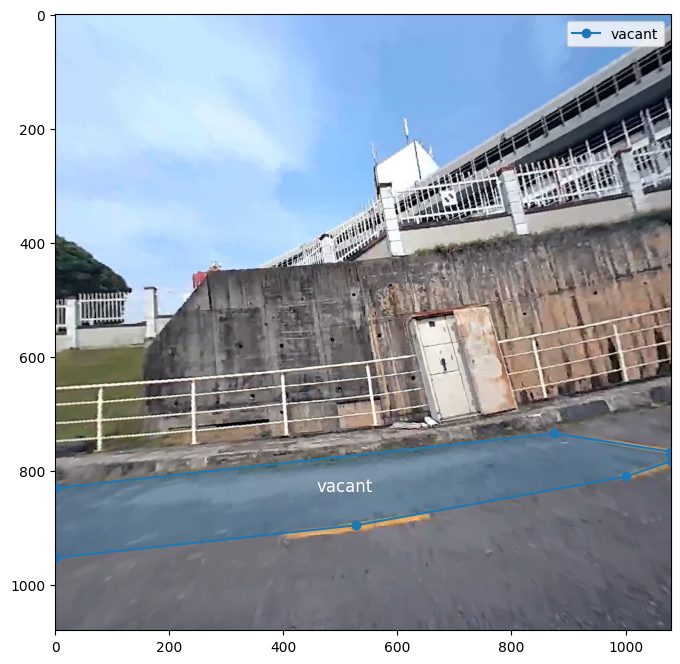

In [14]:
TEST_FILE = "/kaggle/input/surround-view-mmu-parking-slots-dataset/main_data/labels/0926_2284.json"
show_example_from_file(TEST_FILE)

In [15]:
# Process and save train and validation data
ex_ann_train, ex_image_train = save_yolo_format(train_data, "dataset/train/labels")
ex_ann_val, ex_image_val= save_yolo_format(val_data, "dataset/val/labels")

In [16]:
ex_ann_train, ex_image_train

('0 0.5409748829289059 0.7072690506598553 0.33205619412515974 0.08727117922520222 0.7091315453384419 0.7213707960834398 2 0.6474031502767135 0.667092379736058 2 0.43028948488718605 0.6862494678586634 2 0.3770753512132822 0.7543635589612602 2',
 '0926_2497.jpg')

In [17]:
# Save images to respective directories (assuming they're all in one directory)
os.makedirs("dataset/train/images", exist_ok=True)
os.makedirs("dataset/val/images", exist_ok=True)
train_images = train_data.groupby('imagePath')
val_images = val_data.groupby('imagePath')

In [18]:
for image in train_images.groups.keys():
    os.system(f"cp {os.path.join('/kaggle/input/surround-view-mmu-parking-slots-dataset/main_data/images', image)} dataset/train/images/")  # Copy images to train folder

In [19]:
print("Train Images Successfully Pasted")

Train Images Successfully Pasted


In [20]:
for image in val_images.groups.keys():
    os.system(f"cp {os.path.join('/kaggle/input/surround-view-mmu-parking-slots-dataset/main_data/images', image)} dataset/val/images/")  # Copy images to train folder

In [21]:
print("Validation Images Successfully Pasted")

Validation Images Successfully Pasted


In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Define dataset paths
train_images_path = "/kaggle/working/dataset/train/images"
train_labels_path = "/kaggle/working/dataset/train/labels"
val_images_path = "/kaggle/working/dataset/val/images"
val_labels_path = "/kaggle/working/dataset/val/labels"

# Function to display random file and corresponding label
def get_random_file_and_label(images_path, labels_path):
    random_image_file = random.choice(os.listdir(images_path))
    image_file_path = os.path.join(images_path, random_image_file)
    label_file_path = os.path.join(labels_path, random_image_file.replace(".jpg", ".txt").replace(".png", ".txt"))

    with open(label_file_path, 'r') as label_file:
        label_content = label_file.read()

    return os.path.join(images_path, random_image_file), label_content


def draw_bbox_multiple(images_annotations):
    """
    Draws bounding boxes and vertices on multiple images and displays them in subplots.
    :param images_annotations: List of tuples [(image_path, annotation), ...].
    """
    num_images = len(images_annotations)
    cols = 3  # Define the number of columns for subplots
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]

    for idx, (image_path, annotation) in enumerate(images_annotations):
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            axes[idx].axis('off')
            continue

        img = cv2.imread(image_path)
        h, w = img.shape[:2]

        data = list(map(float, annotation.split()))
        class_id = int(data[0])
        x_center, y_center, bbox_width, bbox_height = data[1:5]
        coords = [
            (data[i] * (w if i % 2 == 0 else h), data[i + 1] * (h if i % 2 == 0 else w), int(data[i + 2]))
            for i in range(5, 15, 3)
        ]

        # Filter visible points
        visible_points = [(int(x), int(y)) for x, y, visible in coords if visible == 2]

        # Draw polygon and visible points
        if len(visible_points) >= 3:
            cv2.polylines(img, [np.array(visible_points, dtype=np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
        for x, y in visible_points:
            cv2.circle(img, (x, y), radius=5, color=(0, 255, 0), thickness=-1)

        # Plot the image
        axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f"Class ID: {reverse[class_id]}, Image: {image_path.split('/')[-1]}")
        axes[idx].axis('off')

    # Hide any unused subplot axes
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

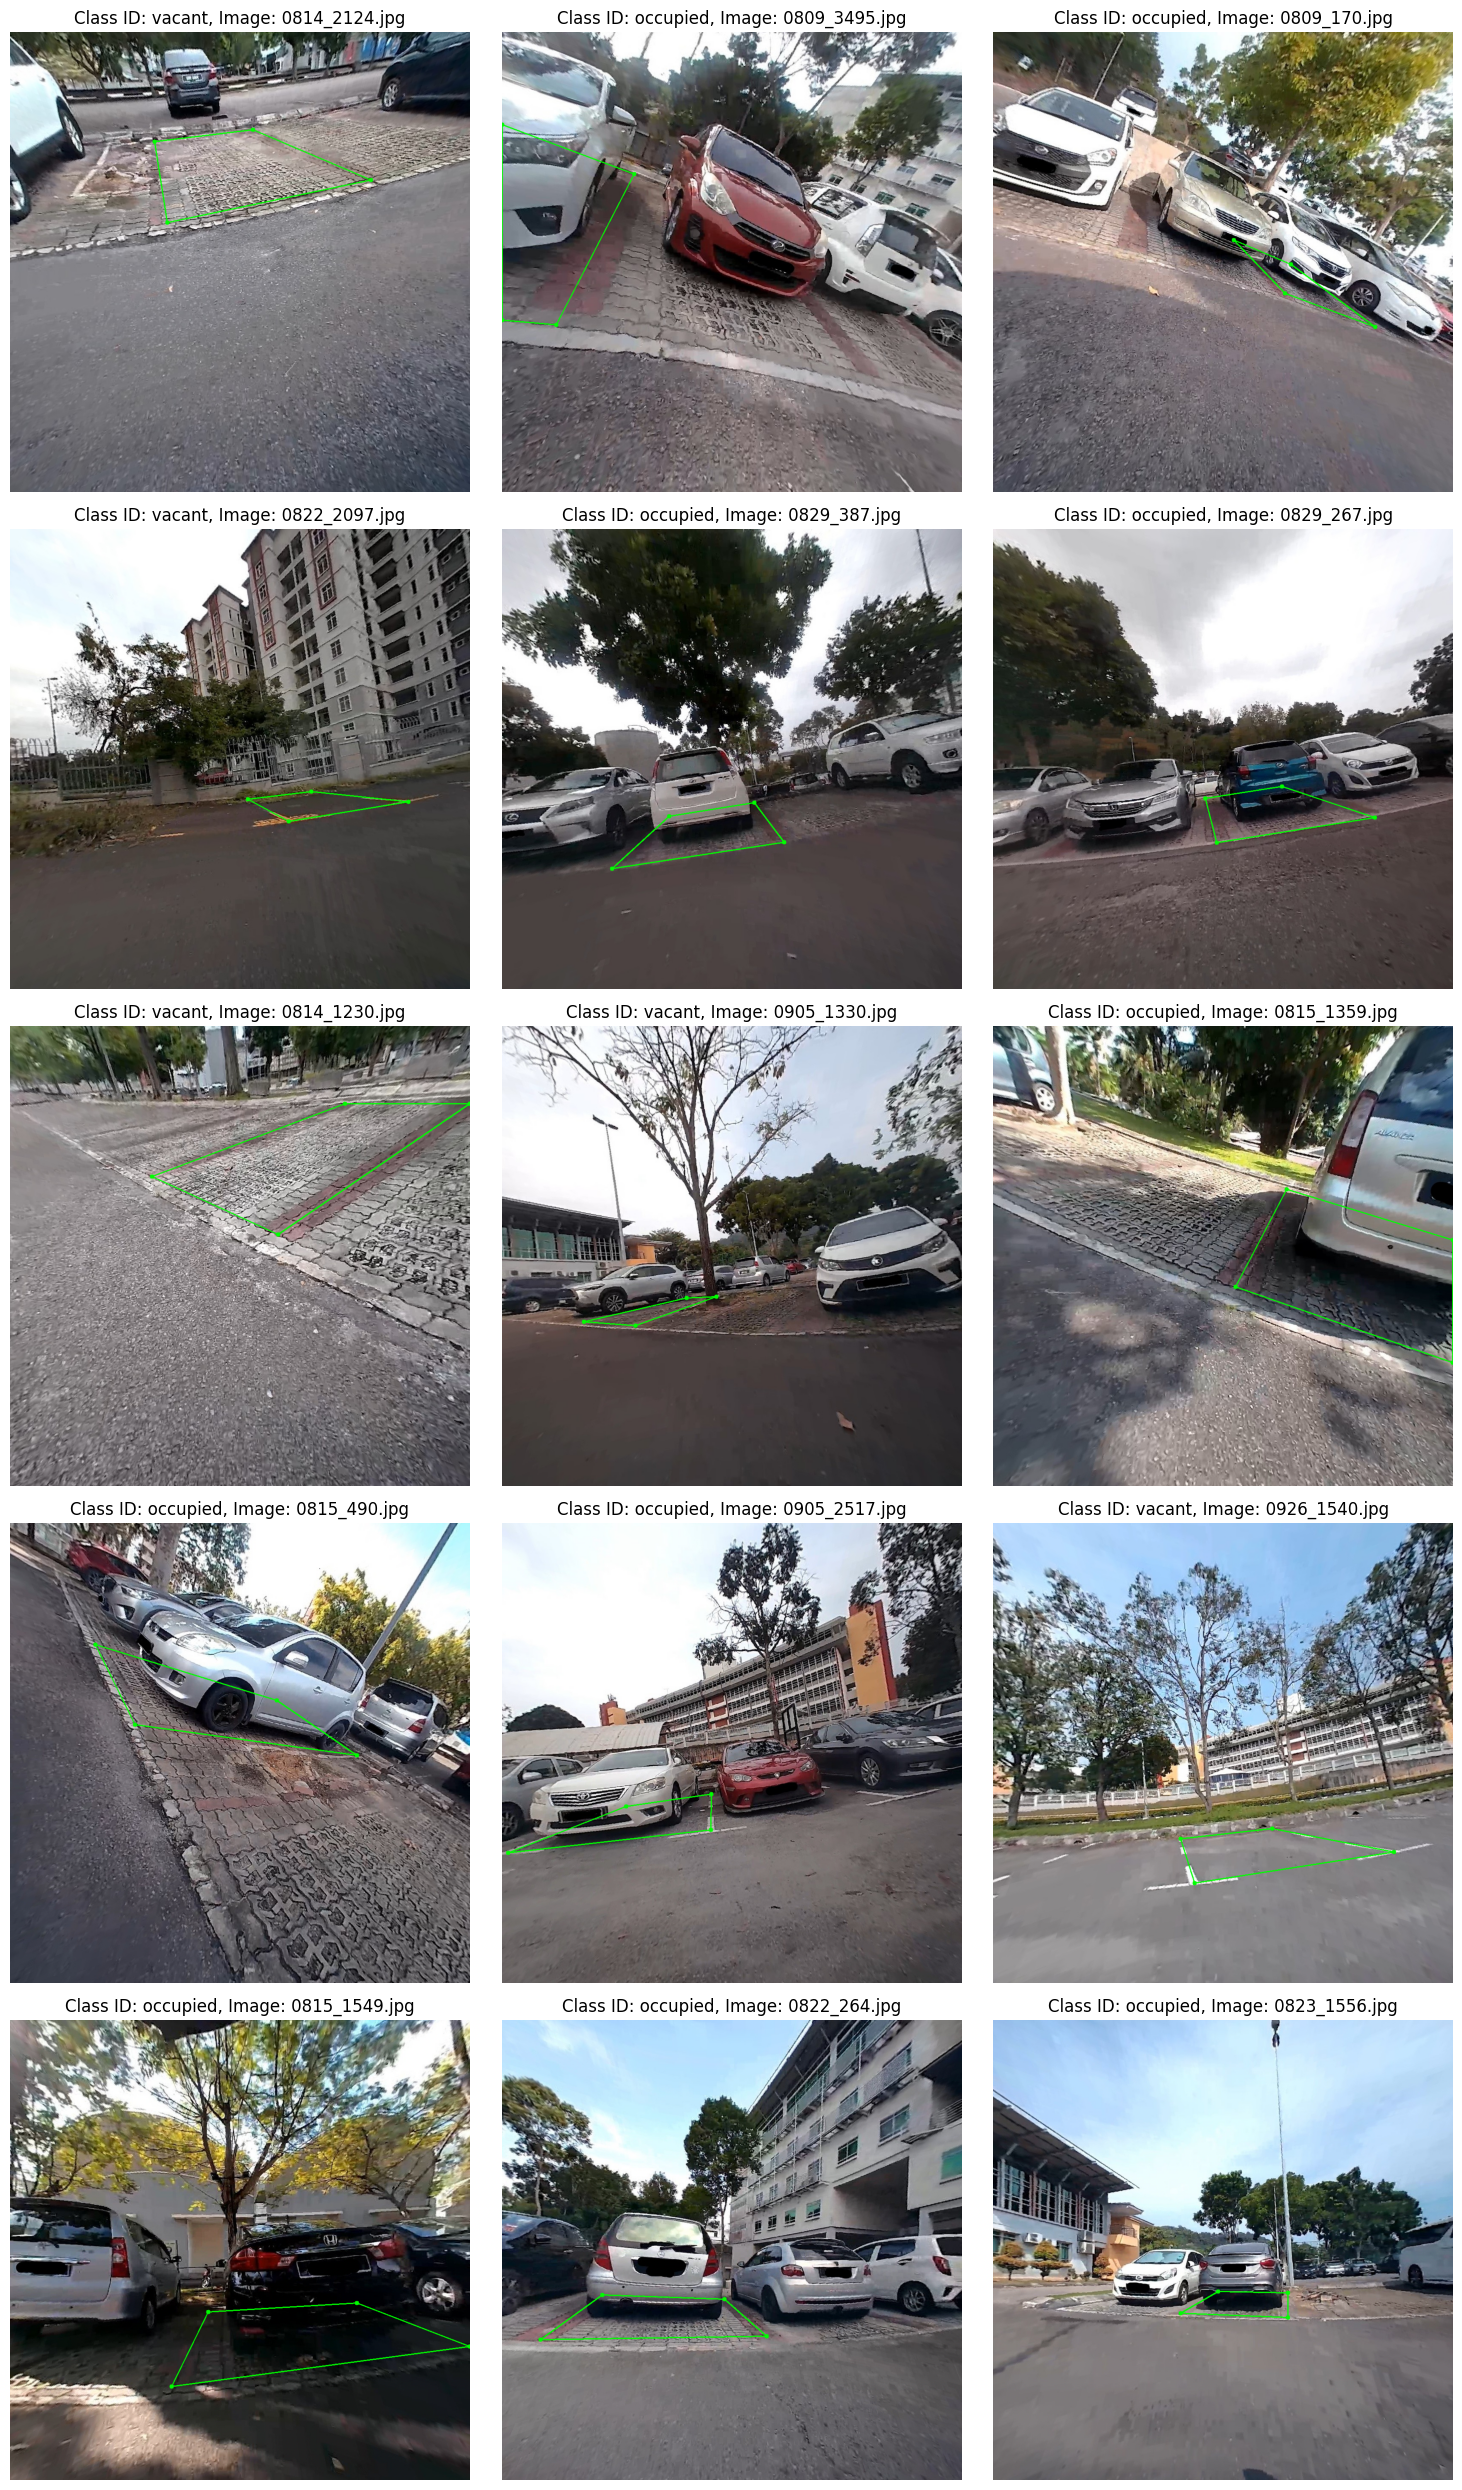

In [23]:
draw_bbox_multiple([get_random_file_and_label(train_images_path, train_labels_path) for i in range(15)])

In [24]:
!pip install ultralytics --upgrade -q

import ultralytics
ultralytics.checks()

Ultralytics 8.3.69 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6095.9/8062.4 GB disk)


In [25]:
import yaml

# Define the data structure
data = {
    "kpt_shape": [4, 3],      # list of integers
    "flip_idx": [1, 0, 3, 2], # list of integers
    "names": {0: "occupied", 1: 'vacant', 2: 'unavailable'},
    "nc": 3,
    "train": "/kaggle/working/dataset/train/images",  # train images (relative to 'path')
    "val": "/kaggle/working/dataset/val/images",      # val images (relative to 'path')
}

# Write to a YAML file
with open("dataset/data.yaml", "w") as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

print("YAML file 'config.yaml' created successfully!")


YAML file 'config.yaml' created successfully!


In [26]:
from ultralytics import YOLO

model = YOLO('yolov8l-pose.pt')

results = model.train(data=f"/kaggle/working/dataset/data.yaml", epochs=50, imgsz=640)

100%|██████████| 85.3M/85.3M [00:00<00:00, 103MB/s]


Ultralytics 8.3.69 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=pose, mode=train, model=yolov8l-pose.pt, data=/kaggle/working/dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

100%|██████████| 755k/755k [00:00<00:00, 26.4MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[4, 3]
Overriding model.yaml nc=1 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train/labels... 9000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9000/9000 [00:08<00:00, 1026.27it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/dataset/val/labels... 2987 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2987/2987 [00:03<00:00, 896.47it/s] 


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 103 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/pose/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.8G      1.832      5.346     0.5023      2.111      1.952         21        640: 100%|██████████| 563/563 [08:59<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


                   all       2987       3239      0.602      0.357      0.262      0.131      0.465      0.184     0.0693      0.014

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.4G      1.725      4.892     0.4393      1.704      1.869         12        640: 100%|██████████| 563/563 [08:53<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:05<00:00,  1.45it/s]


                   all       2987       3239      0.638      0.428      0.339      0.183      0.481      0.224     0.0853     0.0204

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.7G      1.607      4.661     0.4141      1.544      1.788         28        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


                   all       2987       3239      0.386      0.584      0.378      0.211      0.168      0.262     0.0848     0.0206

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.4G      1.526      4.507     0.3994      1.422      1.732         28        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]


                   all       2987       3239      0.473      0.569      0.441      0.269       0.22      0.315      0.114     0.0288

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.7G      1.452       4.34     0.3937      1.316      1.665         18        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.526      0.611      0.487      0.308      0.277      0.318      0.145     0.0405



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.4G      1.398      4.239     0.3859      1.243      1.627         13        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.544      0.626      0.492      0.324      0.254      0.364      0.136     0.0388



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.4G      1.359      4.137     0.3778      1.207      1.593         23        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.506      0.648        0.5      0.333      0.249       0.32      0.138     0.0418



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.4G      1.324      4.097      0.375      1.163      1.567         23        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.541      0.683      0.532      0.366      0.282      0.373      0.174     0.0489



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.2G      1.283      4.013     0.3678      1.125       1.54         20        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239       0.54      0.717      0.536      0.368      0.275      0.389      0.166     0.0502



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.4G      1.268      3.992      0.365      1.093      1.523         23        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.521      0.736      0.539      0.382      0.274      0.405      0.176     0.0558



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.4G      1.239      3.894     0.3683       1.08      1.504         27        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239       0.52      0.775       0.56      0.399      0.274       0.42      0.187     0.0621



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.4G      1.218      3.873     0.3609      1.051      1.487         20        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.538      0.747      0.558      0.396      0.285      0.423      0.187     0.0598



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.2G      1.194      3.786     0.3609      1.026      1.468         22        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.527      0.793      0.575      0.418      0.288      0.432      0.195      0.069



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.4G      1.177       3.78     0.3589      1.013      1.455         23        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239       0.51      0.771       0.57      0.414      0.283      0.438      0.189     0.0698



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.4G      1.158      3.705     0.3566     0.9988      1.442         31        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.561      0.762      0.594      0.437       0.32      0.443      0.206     0.0875



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.4G      1.144       3.65     0.3537     0.9782      1.426         20        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.558      0.749      0.587      0.437      0.329       0.44      0.223     0.0982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.2G      1.131      3.542     0.3498     0.9714       1.42         30        640: 100%|██████████| 563/563 [08:49<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.563      0.746      0.601      0.445      0.337      0.443      0.243      0.101



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.4G      1.119      3.469     0.3529      0.965      1.419         20        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.559      0.768      0.592      0.442      0.342      0.445      0.235      0.108



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.4G      1.115      3.506     0.3475     0.9545      1.416         16        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.561       0.76      0.602      0.452      0.348      0.469      0.248      0.112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.4G      1.103      3.424     0.3459     0.9403      1.402         23        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.558      0.766      0.568      0.424      0.321      0.449      0.206      0.106



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.2G      1.084      3.328      0.342     0.9305      1.389         31        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.555      0.755      0.576      0.434      0.359      0.474      0.242      0.127



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.4G      1.073      3.323     0.3377     0.9138       1.38         13        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.556      0.767      0.569      0.432      0.354      0.491      0.243      0.131



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.4G      1.062      3.213      0.341     0.9091       1.37         28        640: 100%|██████████| 563/563 [08:49<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.541        0.8      0.587      0.447      0.352      0.516      0.254      0.134



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.4G      1.051      3.217     0.3355     0.9015      1.362         18        640: 100%|██████████| 563/563 [08:49<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.556       0.79      0.606      0.461      0.366      0.512      0.272      0.133



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.2G      1.045      3.151     0.3409     0.9037      1.366         17        640: 100%|██████████| 563/563 [08:49<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.557      0.779      0.599       0.46       0.38       0.51      0.295      0.166



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.4G      1.029      3.124      0.337     0.8897      1.352         22        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239       0.54      0.837      0.596      0.457      0.348       0.52      0.258      0.152



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.4G      1.021      3.033      0.331     0.8751      1.345         28        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.565      0.795        0.6      0.462      0.376       0.53      0.277      0.154



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.4G      1.009      3.026     0.3325      0.872      1.332         25        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.559      0.783      0.599       0.46      0.363       0.51      0.257      0.159



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.2G     0.9995      3.002     0.3266      0.867      1.328         21        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.567      0.793      0.618      0.477       0.39      0.534      0.295       0.17



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.4G     0.9935       2.92      0.326     0.8554      1.324         32        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.558      0.805      0.617      0.478      0.398      0.529      0.309      0.183



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.4G     0.9849      2.882     0.3268     0.8441       1.32         18        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.554      0.835      0.625       0.49      0.364      0.551      0.292      0.177



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.4G     0.9726       2.86     0.3249     0.8425      1.314         20        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.555      0.828      0.614      0.482      0.377      0.564      0.293      0.179



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.7G      0.966      2.773     0.3218      0.835      1.308         24        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.566      0.812      0.614      0.483      0.391      0.541      0.297      0.184



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.4G     0.9595      2.754     0.3215     0.8315        1.3         30        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.539       0.84      0.594      0.465      0.407      0.513        0.3      0.189



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.4G     0.9565      2.736     0.3192     0.8269      1.299         14        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.564      0.839      0.618      0.488      0.398      0.592       0.33       0.21



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.9G      0.945       2.68     0.3147     0.8183      1.287         27        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.553      0.832      0.605      0.476      0.388      0.571      0.315      0.206



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.2G     0.9317      2.651     0.3106     0.8096      1.283         32        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.533      0.859      0.617      0.492      0.404       0.55      0.322      0.215



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.4G     0.9249      2.612     0.3146     0.8035      1.277         19        640: 100%|██████████| 563/563 [08:49<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.554       0.83      0.612      0.489      0.396      0.553       0.33      0.212



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.4G     0.9195      2.518     0.3086     0.7892       1.27         19        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.556      0.844       0.62      0.492      0.409      0.556      0.326      0.213



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.4G     0.9163      2.533     0.3098     0.7885       1.27         20        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239       0.55      0.861      0.618      0.494      0.413      0.577      0.344      0.225


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.2G      0.789      2.684     0.1307     0.6534      1.258         13        640: 100%|██████████| 563/563 [08:51<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.565      0.836      0.629      0.505      0.413      0.602      0.351      0.236



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.4G     0.7743      2.581     0.1248     0.6441      1.245         12        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.564      0.841      0.629      0.506      0.411      0.581      0.343      0.232



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.4G      0.765      2.517     0.1238      0.636      1.237         13        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.574      0.808      0.621      0.503      0.429      0.581      0.355      0.251



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.4G     0.7544      2.428     0.1202     0.6277      1.228         14        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.568      0.829      0.639      0.517      0.414      0.594      0.359      0.259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.2G     0.7386      2.378     0.1175     0.6201      1.216         11        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.573      0.827       0.63      0.515      0.426      0.606      0.368      0.267



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.4G     0.7323        2.3     0.1144     0.6163      1.206         10        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.566      0.834      0.628      0.511      0.425       0.59      0.359      0.261



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.4G      0.718      2.267     0.1111     0.6085      1.202         10        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.557      0.819      0.622      0.507      0.423      0.574      0.362      0.261



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.4G     0.7122      2.179     0.1118     0.6034      1.193          8        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]

                   all       2987       3239      0.561      0.836      0.622      0.507      0.417      0.619      0.373      0.269



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.7G      0.705      2.169     0.1054     0.5982      1.186         13        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.557      0.839      0.616      0.503      0.415      0.623      0.369      0.269



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.4G     0.6941      2.107     0.1081     0.5913      1.177         15        640: 100%|██████████| 563/563 [08:50<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:04<00:00,  1.45it/s]

                   all       2987       3239      0.561      0.833      0.622      0.508      0.417      0.602      0.368      0.267



50 epochs completed in 8.298 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 89.4MB
Optimizer stripped from runs/pose/train/weights/best.pt, 89.4MB

Validating runs/pose/train/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8l-pose summary (fused): 287 layers, 44,459,517 parameters, 0 gradients, 168.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:06<00:00,  1.41it/s]


                   all       2987       3239      0.572      0.827       0.63      0.515      0.426      0.607      0.368      0.267
              occupied       1476       1560      0.583      0.872      0.663      0.531      0.418      0.617      0.362      0.253
                vacant       1452       1530      0.569       0.83      0.627      0.523      0.428      0.619      0.389      0.278
           unavailable        147        149      0.564      0.779      0.602      0.492      0.434      0.584      0.354       0.27


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 17.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/pose/train


In [27]:
cat /usr/local/lib/python3.10/dist-packages/ultralytics/utils/callbacks/raytune.py

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

from ultralytics.utils import SETTINGS

try:
    assert SETTINGS["raytune"] is True  # verify integration is enabled
    import ray
    from ray import tune
    from ray.air import session

except (ImportError, AssertionError):
    tune = None


def on_fit_epoch_end(trainer):
    """Sends training metrics to Ray Tune at end of each epoch."""
    if ray.train._internal.session._get_session():  # replacement for deprecated ray.tune.is_session_enabled()
        metrics = trainer.metrics
        session.report({**metrics, **{"epoch": trainer.epoch + 1}})


callbacks = (
    {
        "on_fit_epoch_end": on_fit_epoch_end,
    }
    if tune
    else {}
)


In [28]:
import ray
from ray import tune
from ray.air import session

if ray.train._internal.session._get_session() is not None:
    metrics = trainer.metrics
    metrics['epoch'] = trainer.epoch
    session.report(metrics)